<a href="https://colab.research.google.com/github/ArifAygun/CustomerEye/blob/main/Company_Reviews(1-1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### IMPORT LIBRARIES AND DATASET

In [13]:
!pip install pycountry

In [14]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import pycountry

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive/')

# Change directory to the analysis folder
%cd /content/drive/My Drive/Analysis_1/

# Read CSV files into DataFrames
df1 = pd.read_csv('Freedom_Debt_Relief.csv')
df2 = pd.read_csv('Millennium_Trust.csv')
df3 = pd.read_csv('Advance_America.csv')

print(df1.info(), df1.head())
print(df2.info(), df2.head())
print(df3.info(), df3.head())

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Analysis_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39078 entries, 0 to 39077
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Reviewer Name    39068 non-null  object
 1   Reviews Count    39078 non-null  object
 2   Country Code     39078 non-null  object
 3   Experience Date  39078 non-null  object
 4   Rating           39078 non-null  int64 
 5   Review Date      39078 non-null  object
 6   Review Title     39074 non-null  object
 7   Review Text      34241 non-null  object
 8   Reply Date       37731 non-null  object
 9   Reply Text       37731 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.0+ MB
None     Reviewer Name Reviews Count Country Code    Experience Date  Rating  \
0  Andrea Sciotti      2reviews           US  December 

### DATA PREPROCESSING

In [16]:
# Function for preprocessing
def preprocessing(df, reply_text):
    # Convert 'Reviews Count' to integers
    df['Reviews Count'] = df['Reviews Count'].str.extract('(\d+)').astype(int)

    # Replace the specified text in 'Reply Date' column
    df['Reply Date'] = df['Reply Date'].str.replace(reply_text, '').str.strip()

    # Convert 'Experience Date', 'Review Date', and 'Reply Date' to datetime
    date_columns = ['Experience Date', 'Review Date', 'Reply Date']
    df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')

    # Extract 'Year' from 'Review Date' and create a new column
    df['Year'] = df['Review Date'].dt.year

    # Drop rows with NaN values in 'Experience Date', 'Review Date', or 'Reply Date'
    df = df.dropna(subset=date_columns)

    # Create a copy to avoid SettingWithCopyWarning
    df = df.copy()

    # Concatenate 'Review Title' and 'Review Text' into a new 'Reviews' column
    df.loc[:, 'Reviews'] = df['Review Title'].astype(str) + ' ' + df['Review Text'].astype(str)

    # Rename 'Reply Text' column to 'Replies'
    df = df.rename(columns={'Reply Text': 'Replies', 'Country Code': 'Country'})

    # Add a new column with country names
    df['Countries'] = df['Country'].apply(lambda code: pycountry.countries.get(alpha_2=code).name if pycountry.countries.get(alpha_2=code) else None)

    # Calculate response time between 'Experience Date' and 'Review Date' in days
    df['Exp to Review'] = (df['Review Date'] - df['Experience Date']).dt.total_seconds() / 86400

    # Calculate response time between 'Review Date' and 'Reply Date' in days
    df['Review to Reply'] = (df['Reply Date'] - df['Review Date']).dt.total_seconds() / 86400

    # Round the values to the nearest integer and convert to int
    df[['Exp to Review', 'Review to Reply']] = df[['Exp to Review', 'Review to Reply']].round(0).astype(int)

    # Drop the original 'Review Title' and 'Review Text' columns
    df = df.drop(['Reviewer Name', 'Reviews Count', 'Review Title', 'Review Text','Country'], axis=1)

    # Rearrange the columns
    df = df[['Year', 'Experience Date', 'Review Date', 'Reply Date','Exp to Review',
             'Review to Reply','Rating', 'Countries', 'Reviews', 'Replies']]

    return df

# Calculate response time for each DataFrame
df1 = preprocessing(df1, 'Reply from Freedom Debt Relief')
df2 = preprocessing(df2, 'Reply from Millennium Trust')
df3 = preprocessing(df3, 'Reply from Advance America')

# Print the updated DataFrame information
pd.set_option('display.max_columns', None)

print(df1.info())
print(df2.info())
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36713 entries, 0 to 39077
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Year             36713 non-null  float64       
 1   Experience Date  36713 non-null  datetime64[ns]
 2   Review Date      36713 non-null  datetime64[ns]
 3   Reply Date       36713 non-null  datetime64[ns]
 4   Exp to Review    36713 non-null  int64         
 5   Review to Reply  36713 non-null  int64         
 6   Rating           36713 non-null  int64         
 7   Countries        36713 non-null  object        
 8   Reviews          36713 non-null  object        
 9   Replies          36713 non-null  object        
dtypes: datetime64[ns](3), float64(1), int64(3), object(3)
memory usage: 3.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29374 entries, 235 to 39327
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  

### DATA SAMPLING

In [17]:
# Function for random sampling
def perform_sampling(df):
    years_to_keep = [2021, 2022, 2023]

    # Filter data for the specified years
    filtered_df = df[df['Review Date'].dt.year.isin(years_to_keep)]

    # Count the occurrences of each rating for each year
    yearly_rating_counts = filtered_df.groupby(['Year', 'Rating']).size().unstack(fill_value=0)

    # Perform random sampling to get 2000 datapoints
    sampled_df = pd.DataFrame()
    for year in years_to_keep:
        year_data = filtered_df[filtered_df['Review Date'].dt.year == year]
        sampled_data = year_data.sample(n=2000, replace=True)  # Adjust the sampling size as needed
        sampled_df = pd.concat([sampled_df, sampled_data])

    return sampled_df

# Apply sampling for each dataset
sampled_df1 = perform_sampling(df1)
sampled_df2 = perform_sampling(df2)
sampled_df3 = perform_sampling(df3)

# Ensure all sampled dataframes have the same number of datapoints (2000)
sampled_df1 = sampled_df1.sample(n=2000, replace=True)
sampled_df2 = sampled_df2.sample(n=2000, replace=True)
sampled_df3 = sampled_df3.sample(n=2000, replace=True)

print(sampled_df1.info())
print(sampled_df2.info())
print(sampled_df3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 34588 to 35209
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Year             2000 non-null   float64       
 1   Experience Date  2000 non-null   datetime64[ns]
 2   Review Date      2000 non-null   datetime64[ns]
 3   Reply Date       2000 non-null   datetime64[ns]
 4   Exp to Review    2000 non-null   int64         
 5   Review to Reply  2000 non-null   int64         
 6   Rating           2000 non-null   int64         
 7   Countries        2000 non-null   object        
 8   Reviews          2000 non-null   object        
 9   Replies          2000 non-null   object        
dtypes: datetime64[ns](3), float64(1), int64(3), object(3)
memory usage: 171.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 6936 to 21370
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         


## RATINGS OVER YEARS

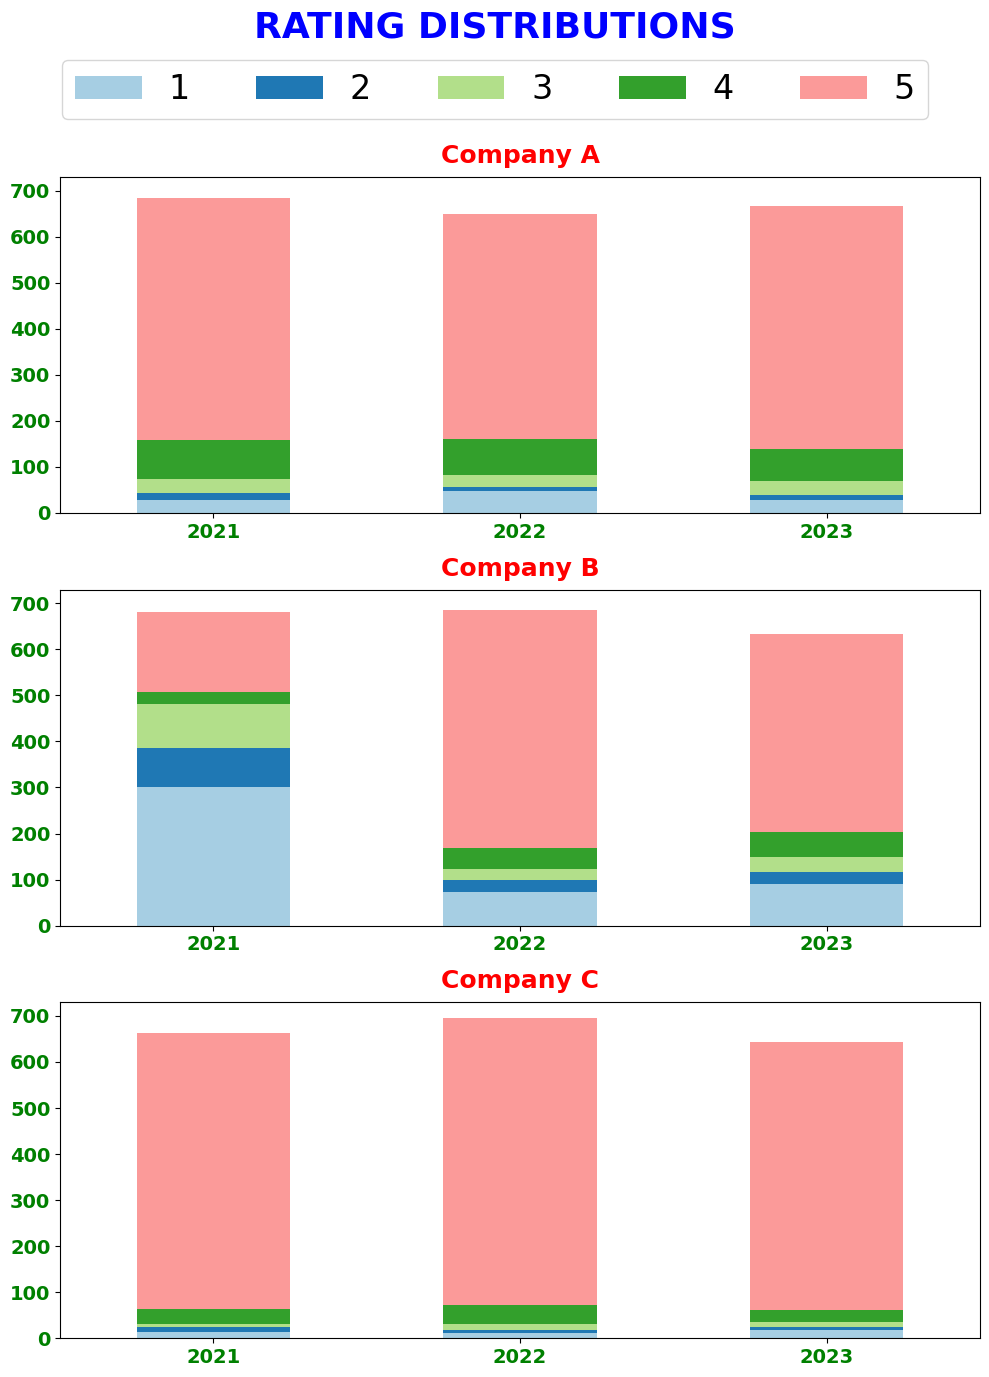

In [18]:
from matplotlib.ticker import FixedLocator

# Create a figure with three subplots for vertical stacked bar charts
fig, axes = plt.subplots(3, 1, figsize=(10, 14), sharey=True)

# Set Seaborn color palette to "Paired"
sns.set_palette("Paired")

# Lists to collect handles and labels for the legend
handles = []
labels = set()  # Using a set to avoid duplicates in labels

# Plot vertical stacked bars for each rating for each DataFrame
for i, df in enumerate([sampled_df1, sampled_df2, sampled_df3]):
    yearly_rating_counts = df.groupby(['Year', 'Rating']).size().unstack(fill_value=0)

    # Cast the years to integers
    yearly_rating_counts.index = yearly_rating_counts.index.astype(int)

    plot = yearly_rating_counts.plot(kind='bar', stacked=True, ax=axes[i], legend=False)

    # Collect handles and labels for the legend
    plot_handles, plot_labels = axes[i].get_legend_handles_labels()
    handles.extend(plot_handles)

    # Use set union to add unique labels to the set
    labels |= set(plot_labels)

    # Set labels and title for each subplot
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_title(f'Company {chr(ord("A") + i)}', fontsize=18, color='red', fontweight='bold', pad=10)  # Adjust the 'pad' value as needed

    # Remove decimals in the x-axis labels
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Rotate x-axis labels to be horizontal
    plt.setp(axes[i].get_xticklabels(), rotation=0, ha="center", fontsize=14, fontweight='bold', color='green')

    # Make y-axis labels bold and set font size using FixedLocator and FixedFormatter
    yticks = [int(ytick) for ytick in axes[i].get_yticks()]
    axes[i].yaxis.set_major_locator(FixedLocator(yticks))
    axes[i].set_yticklabels(yticks, fontsize=14, fontweight='bold', color='green')

# Sort labels in ascending order
sorted_labels = sorted(labels, key=lambda x: int(x))

# Create a combined legend for all plots horizontally with adjusted parameters
legend = fig.legend(handles, sorted_labels, loc='lower center', bbox_to_anchor=(0.5, 0.91), ncol=5, borderaxespad=0.5, prop={'size': 24})

# Set legend title font size
legend.get_title().set_fontsize(14)

# Set a general title for the entire subplot
fig.suptitle('RATING DISTRIBUTIONS', fontsize=26, color='blue', fontweight='bold', y=1)

# Adjust layout
plt.tight_layout(rect=[0, 0.02, 1, 0.95])

# Show the vertical stacked bar charts with a single legend at the bottom
plt.show()


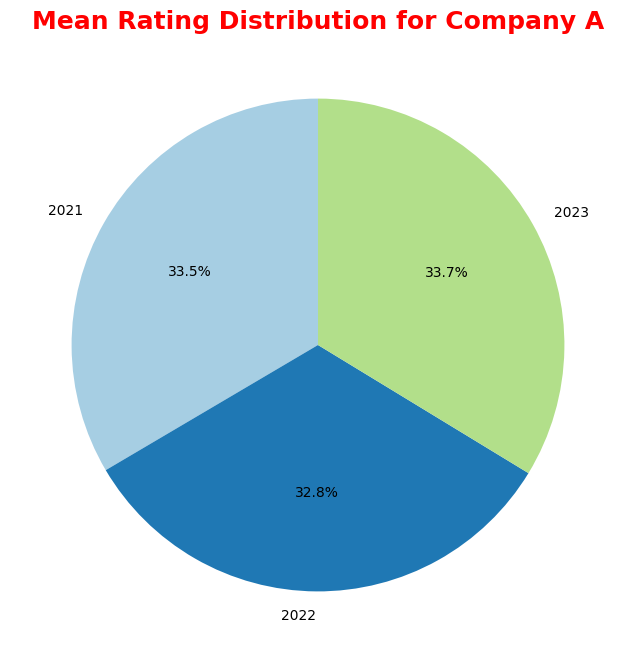

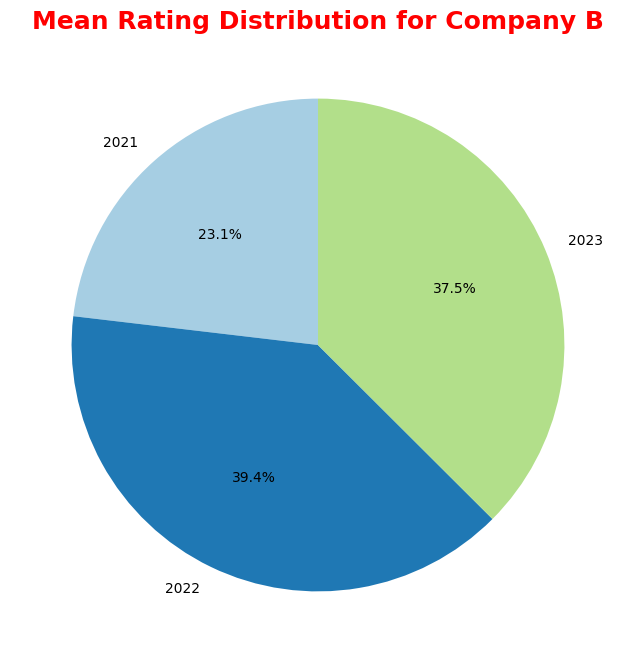

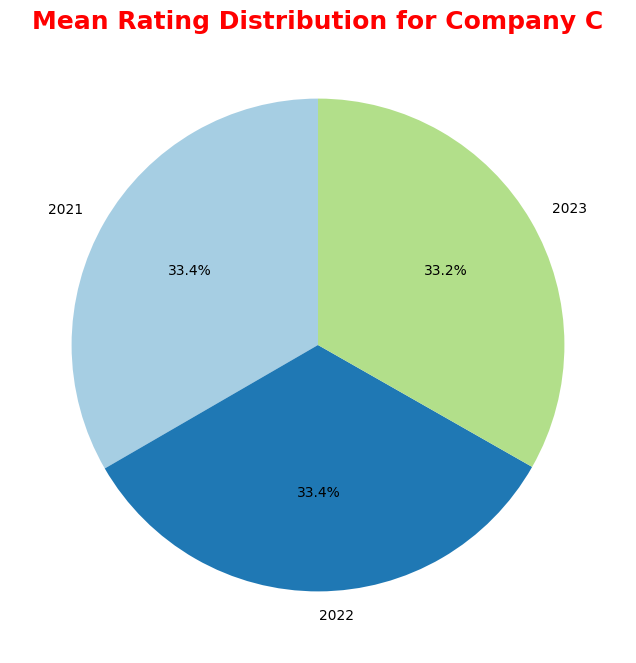

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming sampled_df1, sampled_df2, and sampled_df3 are your three DataFrames

# Create a function to plot pie charts for mean ratings by year
def plot_pie_ratings(df, company_name, color_palette):
    yearly_mean_ratings = df.groupby('Year')['Rating'].mean()

    # Create a pie chart
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(yearly_mean_ratings, labels=yearly_mean_ratings.index.astype(int), autopct='%1.1f%%', startangle=90,
           colors=sns.color_palette(color_palette))

    # Set title for the pie chart
    ax.set_title(f'Mean Rating Distribution for {company_name}', fontsize=18, color='red', fontweight='bold')

    # Show the pie chart
    plt.show()

# Plot pie charts for mean ratings for each company
plot_pie_ratings(sampled_df1, 'Company A', 'Paired')
plot_pie_ratings(sampled_df2, 'Company B', 'Paired')
plot_pie_ratings(sampled_df3, 'Company C', 'Paired')


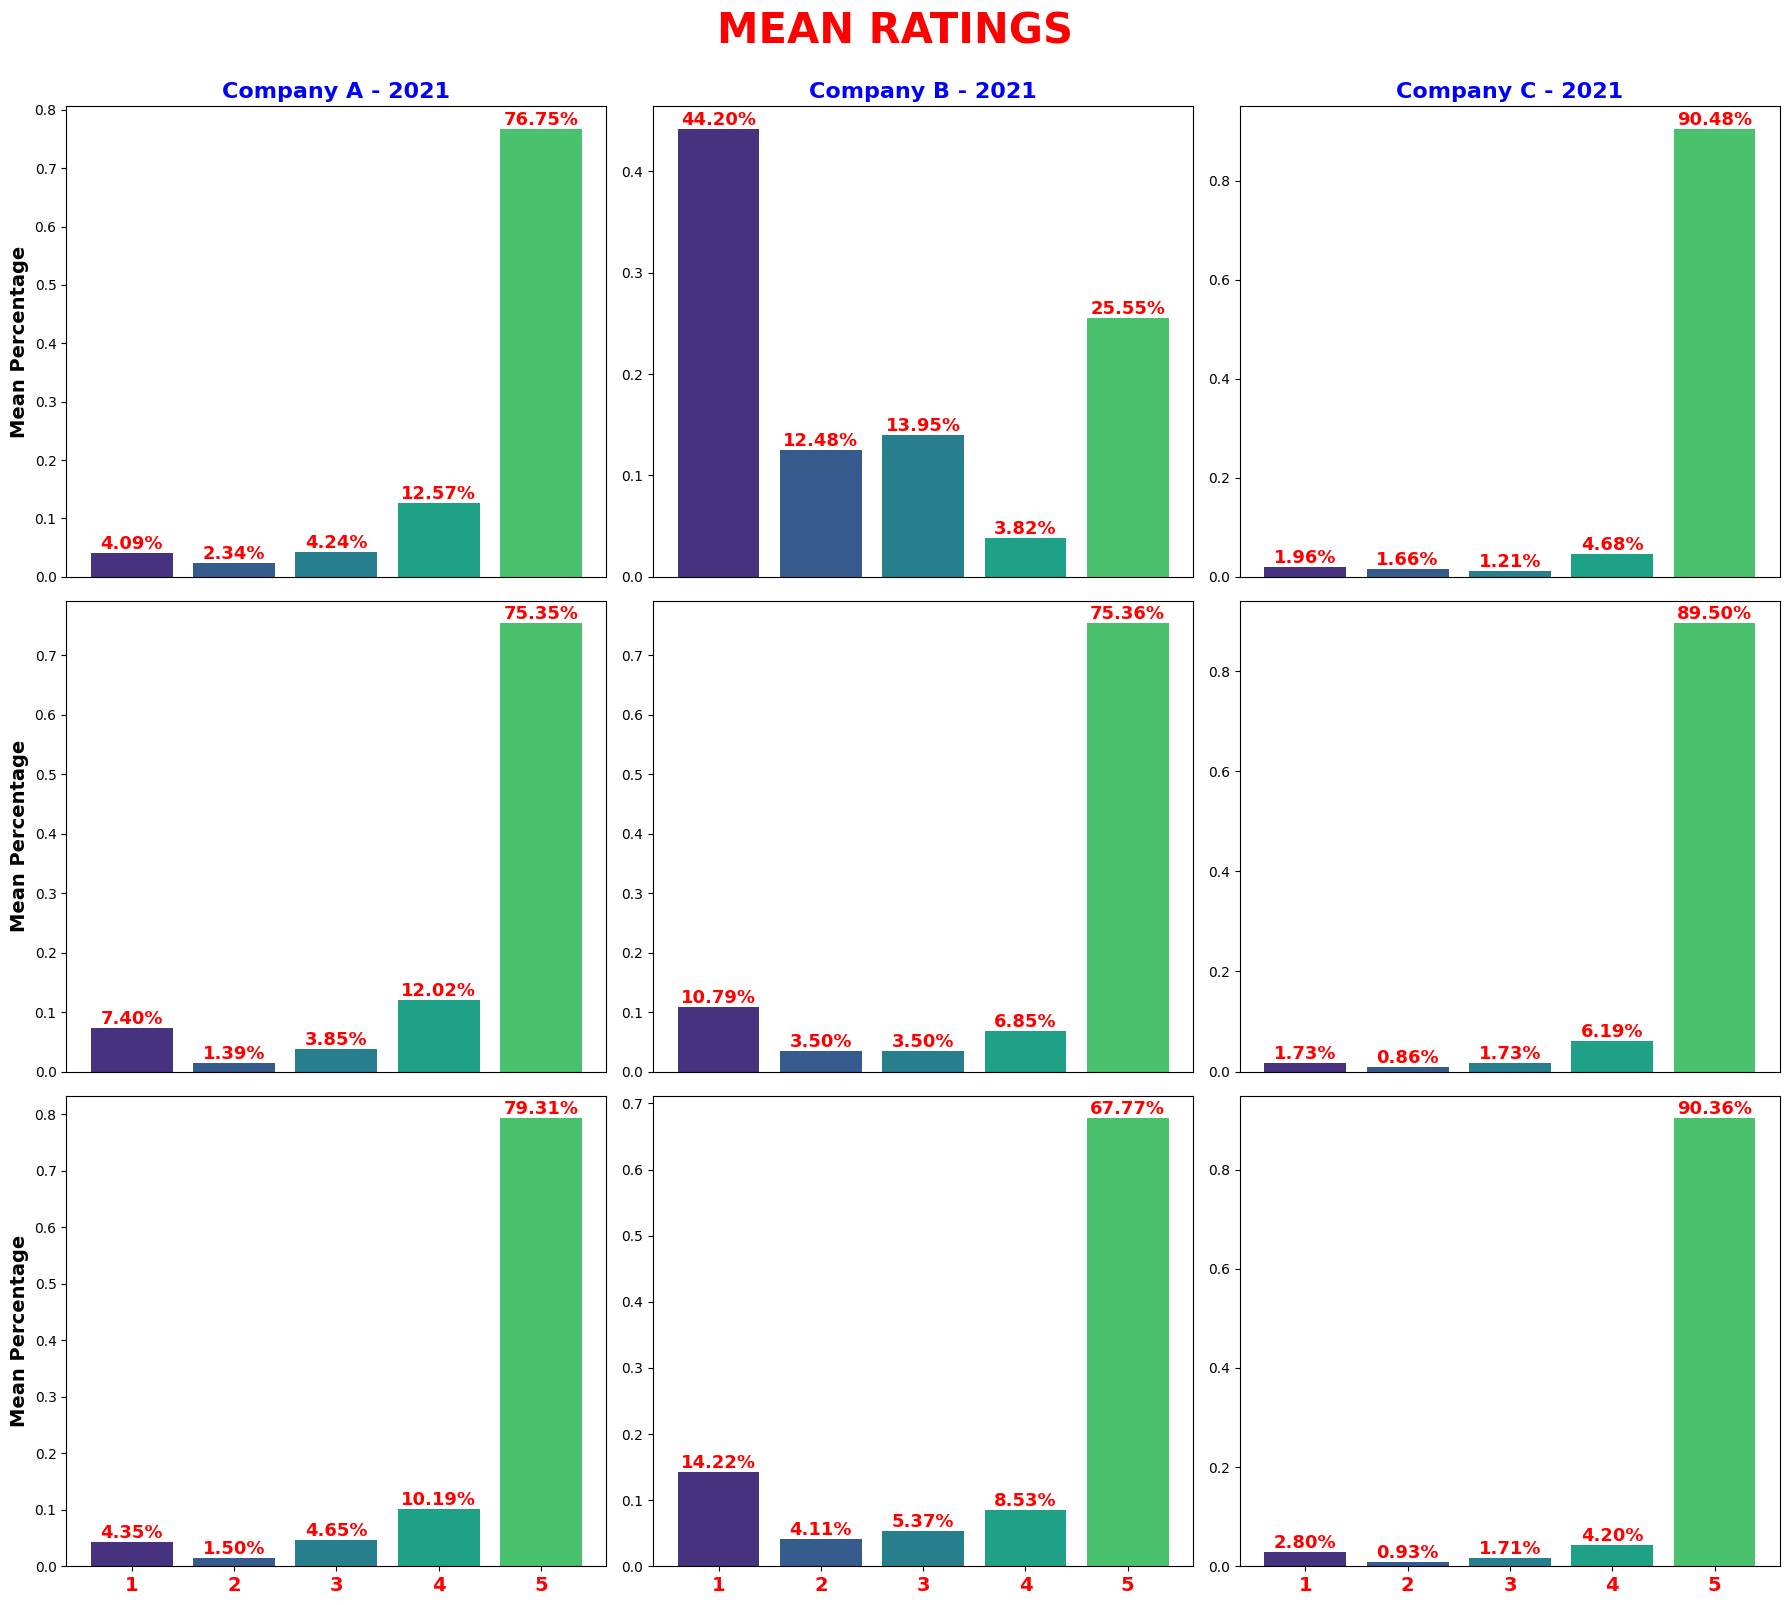

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming sampled_df1, sampled_df2, and sampled_df3 are your DataFrames for companies A, B, and C
companies = [sampled_df1, sampled_df2, sampled_df3]
company_names = ['Company A', 'Company B', 'Company C']

# Define years to plot
years = [2021, 2022, 2023]

# General title for the entire subplot
general_title = 'MEAN RATINGS'

# Plot bar charts for mean ratings for each company and year
plt.figure(figsize=(18, 16))

for i, company_df in enumerate(companies):
    for j, year in enumerate(years):
        company_year = company_df[company_df['Year'] == year]
        mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

        # Plot the bar chart
        subplot_index = j * len(companies) + i + 1
        ax = plt.subplot(len(years), len(companies), subplot_index)

        # Manually set xticks for the last row
        bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

        # Set xticks for the last row
        if j == len(years) - 1:
            plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=14, fontweight='bold', color='red')
        else:
            plt.xticks([])

        # Add labels and title
        if j == 0:
            plt.title(f'{company_names[i]} - {year}', fontsize=16, fontweight='bold', color='blue')

        if i == 0:
            plt.ylabel('Mean Percentage', fontsize=14, fontweight='bold')

        # Add bar labels with specified properties
        for bar, value in zip(bars, mean_ratings.values):
            plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

# Set x-axis labels for the last row
plt.xticks(range(1, 6), labels=[str(i) for i in range(1, 6)], fontsize=14, fontweight='bold', color='red')

# General title for the entire subplot
plt.suptitle(general_title, fontsize=30, fontweight='bold', y=1, color='red')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


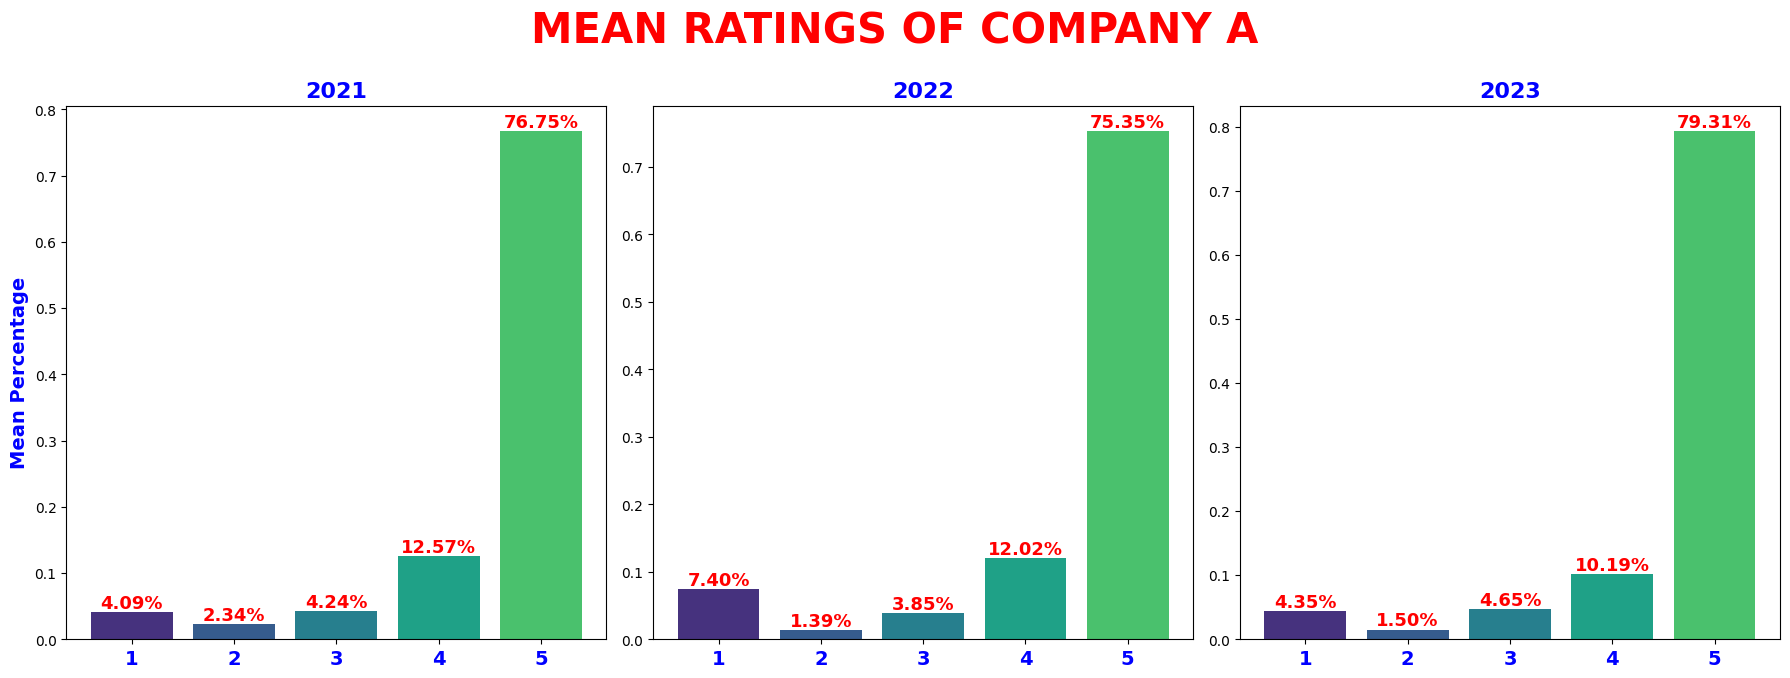

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming sampled_df1 is your DataFrame for Company A
company_df = sampled_df1

# Define years to plot
years = [2021, 2022, 2023]

# General title for the entire subplot
general_title = 'MEAN RATINGS OF COMPANY A'

# Plot bar charts for mean ratings for Company A for each year
plt.figure(figsize=(18, 18))

for i, year in enumerate(years):
    company_year = company_df[company_df['Year'] == year]
    mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

    # Plot the bar chart
    subplot_index = i + 1
    ax = plt.subplot(3, 3, subplot_index)

    # Manually set xticks for the last row
    bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

    # Set xticks for the last row
    plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=14, fontweight='bold', color='blue')

    # Add labels and title
    plt.title(f'{year}', fontsize=16, fontweight='bold', color='blue')

    # Add y-labels for the first column
    if subplot_index % 3 == 1:
        plt.ylabel('Mean Percentage', fontsize=14, fontweight='bold', color='blue')

    # Add bar labels with specified properties
    for bar, value in zip(bars, mean_ratings.values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

# General title for the entire subplot
plt.suptitle(general_title, fontsize=30, fontweight='bold', y=1, color='red')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


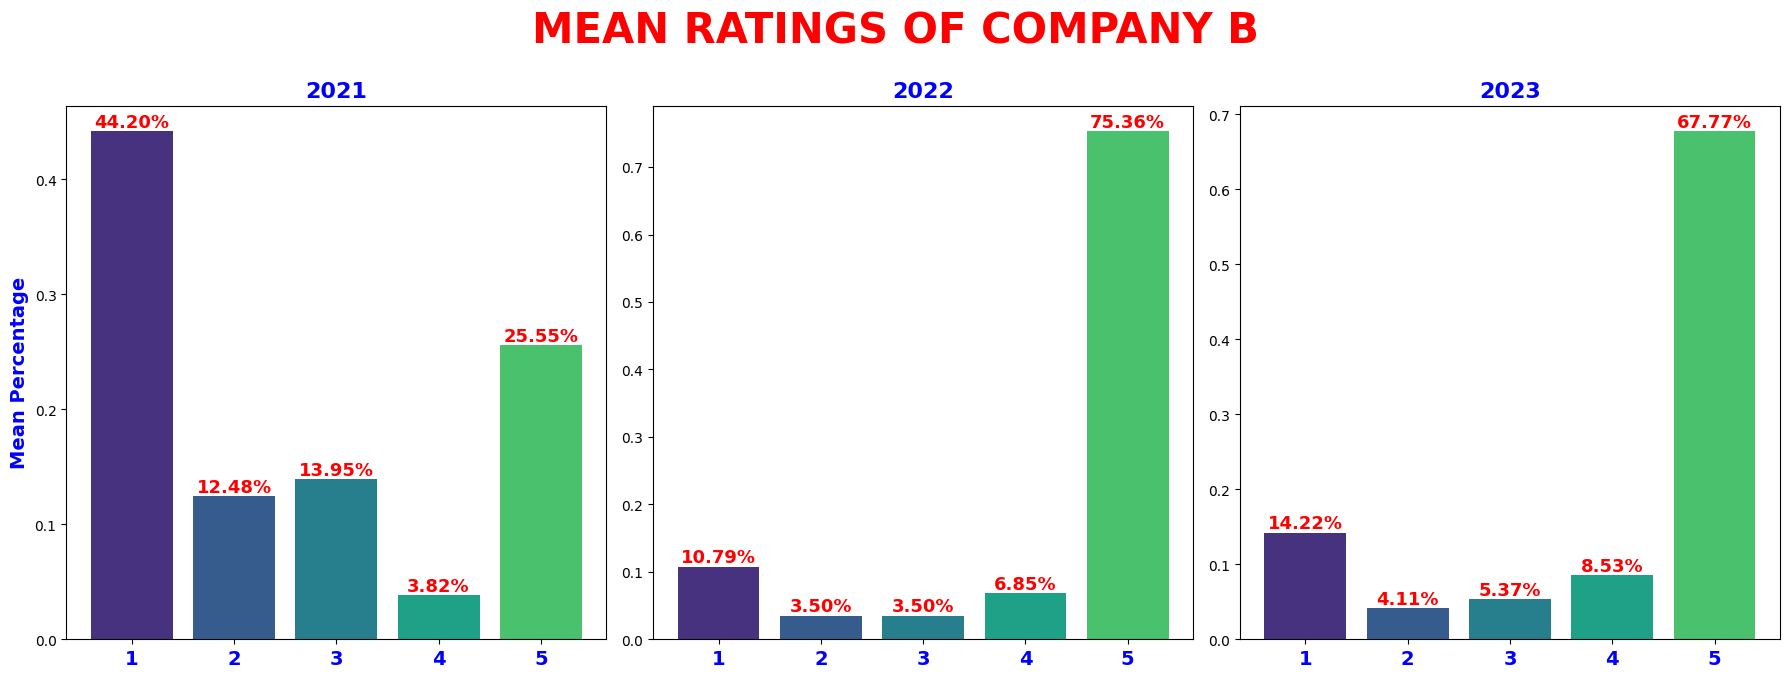

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming sampled_df2 is your DataFrame for Company B
company_df = sampled_df2

# Define years to plot
years = [2021, 2022, 2023]

# General title for the entire subplot
general_title = 'MEAN RATINGS OF COMPANY B'

# Plot bar charts for mean ratings for Company B for each year
plt.figure(figsize=(18, 18))

for i, year in enumerate(years):
    company_year = company_df[company_df['Year'] == year]
    mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

    # Plot the bar chart
    subplot_index = i + 1
    ax = plt.subplot(3, 3, subplot_index)

    # Manually set xticks for the last row
    bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

    # Set xticks for the last row
    plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=14, fontweight='bold', color='blue')

    # Add labels and title
    plt.title(f'{year}', fontsize=16, fontweight='bold', color='blue')

    # Add y-labels for the first column
    if subplot_index % 3 == 1:
        plt.ylabel('Mean Percentage', fontsize=14, fontweight='bold', color='blue')

    # Add bar labels with specified properties
    for bar, value in zip(bars, mean_ratings.values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

# General title for the entire subplot
plt.suptitle(general_title, fontsize=30, fontweight='bold', y=1, color='red')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


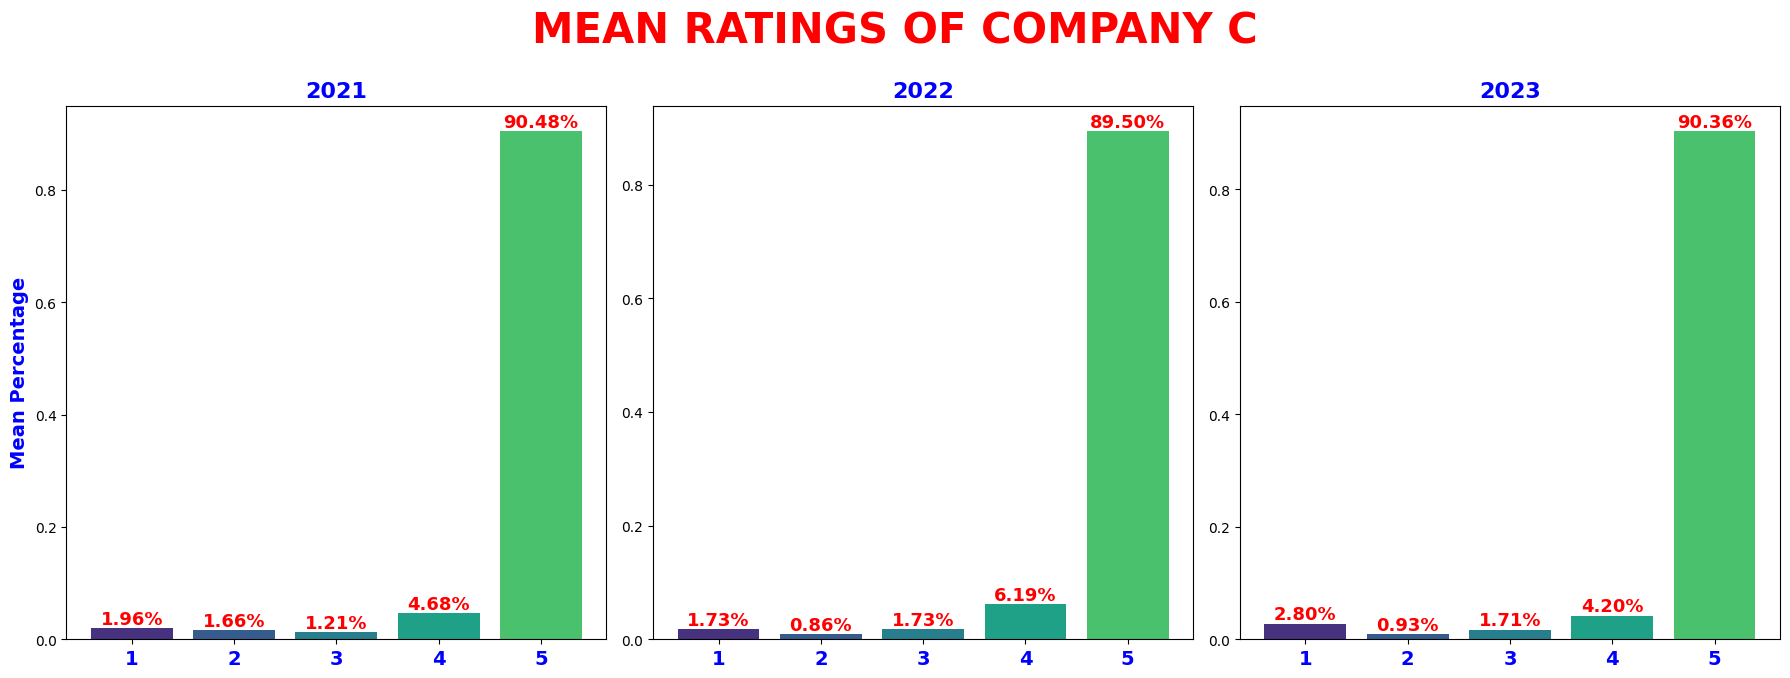

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming sampled_df3 is your DataFrame for Company C
company_df = sampled_df3

# Define years to plot
years = [2021, 2022, 2023]

# General title for the entire subplot
general_title = 'MEAN RATINGS OF COMPANY C'

# Plot bar charts for mean ratings for Company C for each year
plt.figure(figsize=(18, 18))

for i, year in enumerate(years):
    company_year = company_df[company_df['Year'] == year]
    mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

    # Plot the bar chart
    subplot_index = i + 1
    ax = plt.subplot(3, 3, subplot_index)

    # Manually set xticks for the last row
    bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

    # Set xticks for the last row
    plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=14, fontweight='bold', color='blue')

    # Add labels and title
    plt.title(f'{year}', fontsize=16, fontweight='bold', color='blue')

    # Add y-labels for the first column
    if subplot_index % 3 == 1:
        plt.ylabel('Mean Percentage', fontsize=14, fontweight='bold', color='blue')

    # Add bar labels with specified properties
    for bar, value in zip(bars, mean_ratings.values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

# General title for the entire subplot
plt.suptitle(general_title, fontsize=30, fontweight='bold', y=1, color='red')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


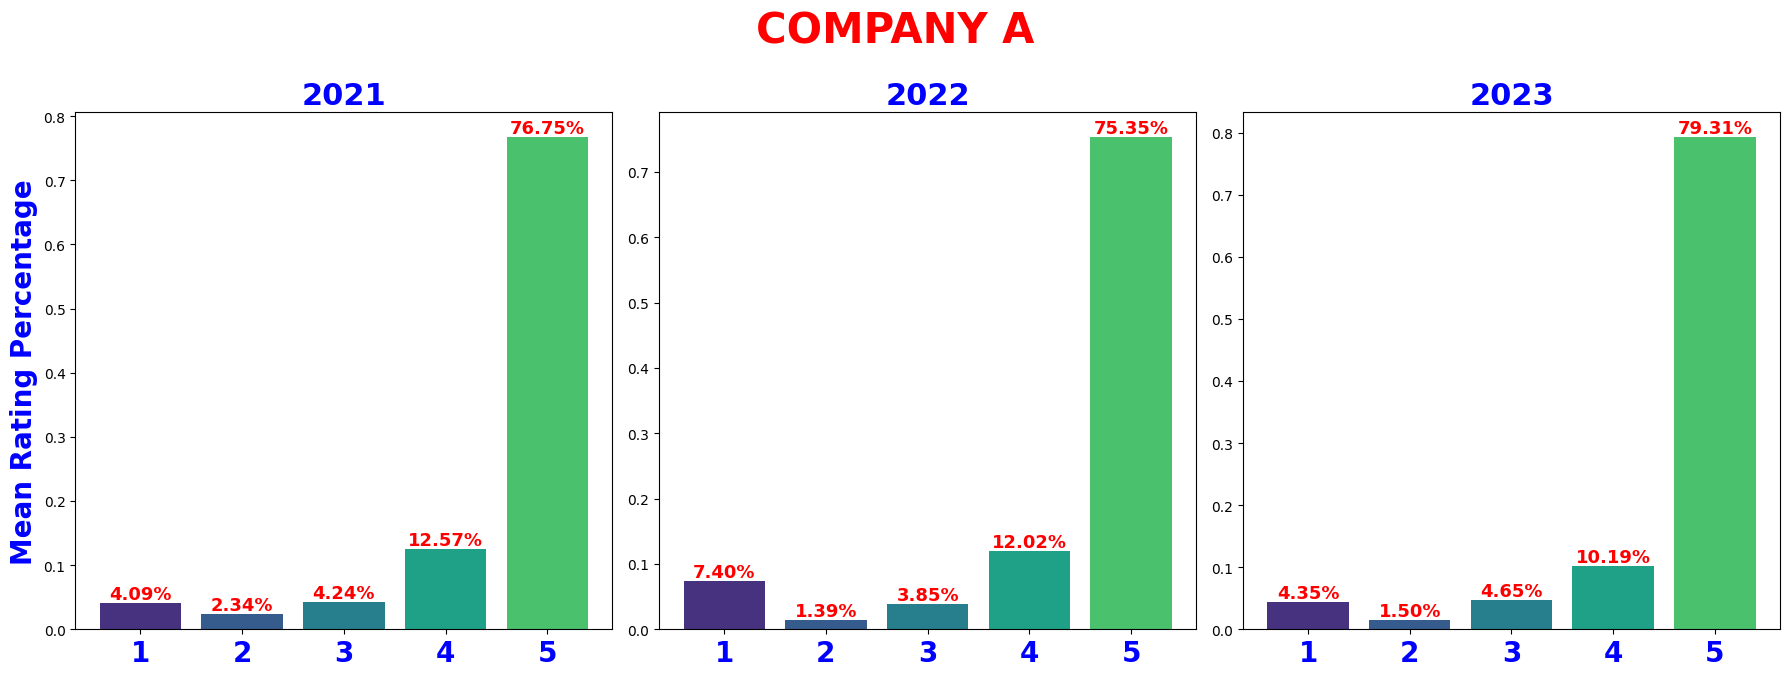

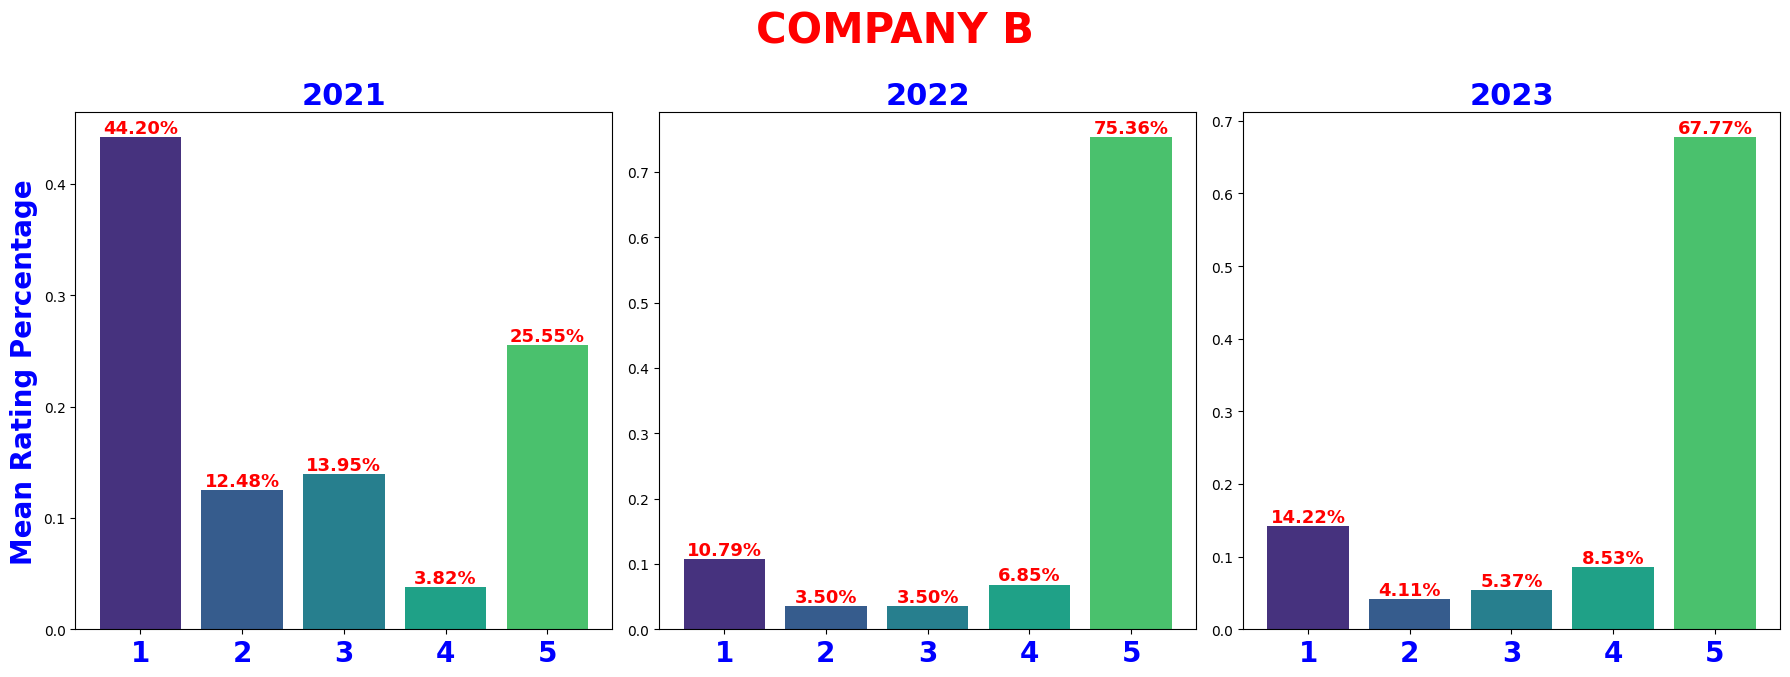

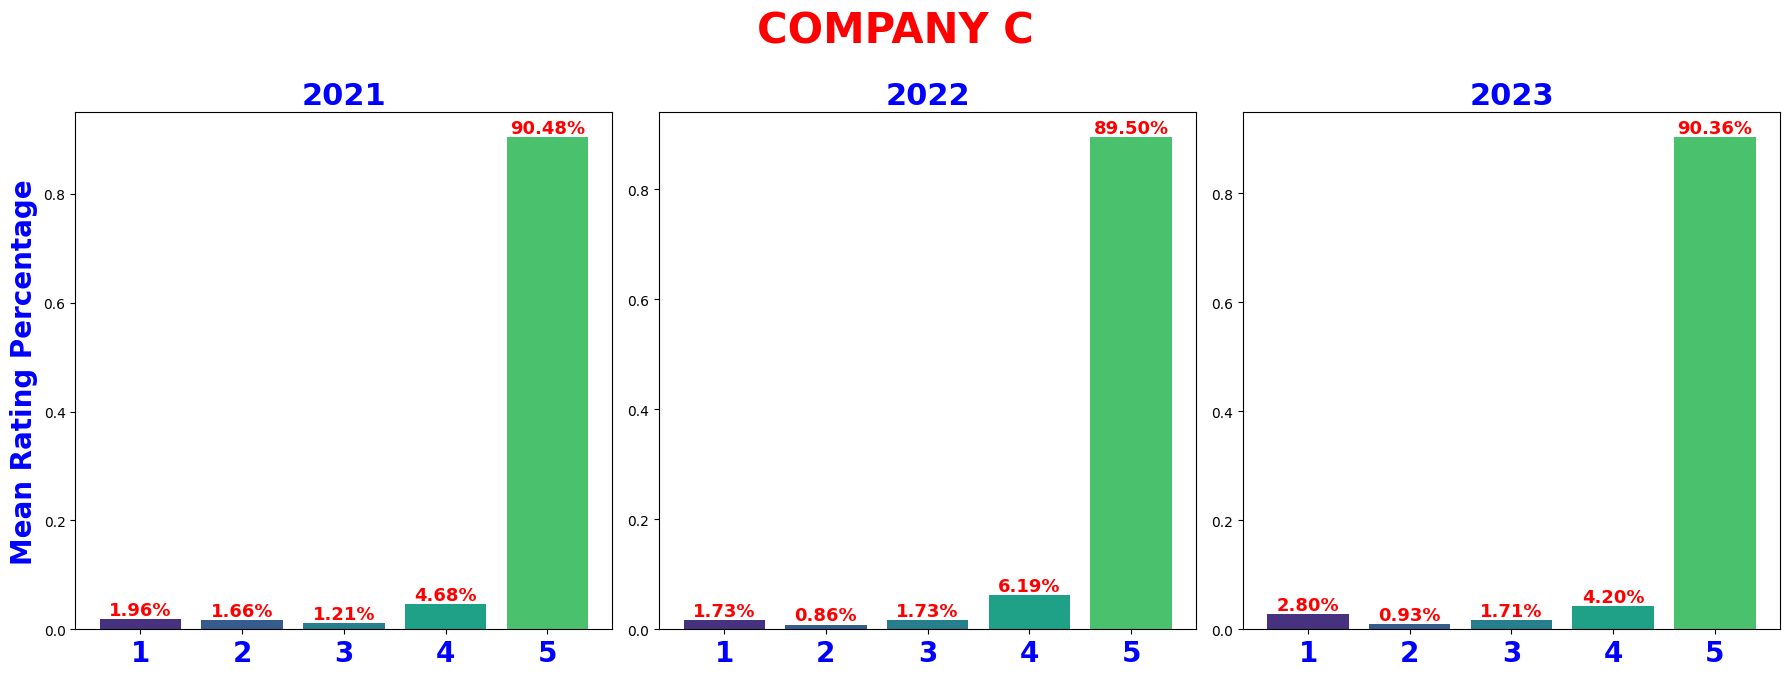

In [24]:
def plot_company_mean_ratings(company_df, company_name):
    # Define years to plot
    years = [2021, 2022, 2023]

    # General title for the entire subplot
    general_title = f'{company_name}'

    # Plot bar charts for mean ratings for the company for each year
    plt.figure(figsize=(18, 18))

    for i, year in enumerate(years):
        company_year = company_df[company_df['Year'] == year]
        mean_ratings = company_year.groupby('Rating')['Rating'].count() / len(company_year)

        # Plot the bar chart
        subplot_index = i + 1
        ax = plt.subplot(3, 3, subplot_index)

        # Manually set xticks for the last row
        bars = plt.bar(mean_ratings.index, mean_ratings.values, color=sns.color_palette("viridis"))

        # Set xticks for the last row
        plt.xticks(ticks=mean_ratings.index, labels=mean_ratings.index.astype(str), fontsize=20, fontweight='bold', color='blue')

        # Add labels and title
        plt.title(f'{year}', fontsize=22, fontweight='bold', color='blue')

        # Add y-labels for the first column
        if subplot_index % 3 == 1:
            plt.ylabel('Mean Rating Percentage', fontsize=20, fontweight='bold', color='blue')

        # Add bar labels with specified properties
        for bar, value in zip(bars, mean_ratings.values):
            plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

    # General title for the entire subplot
    plt.suptitle(general_title, fontsize=30, fontweight='bold', y=1, color='red')

    # Adjust layout with a gap between subplots
    plt.tight_layout(h_pad=2)

    # Show the plot
    plt.show()

# Assuming sampled_df1, sampled_df2, and sampled_df3 are your DataFrames for companies A, B, and C
plot_company_mean_ratings(sampled_df1, 'COMPANY A')
plot_company_mean_ratings(sampled_df2, 'COMPANY B')
plot_company_mean_ratings(sampled_df3, 'COMPANY C')

### Visualization for Mean Rating by Year and Month:

a. Calculate summary statistics for different time periods, such as the mean rating for each year or month.

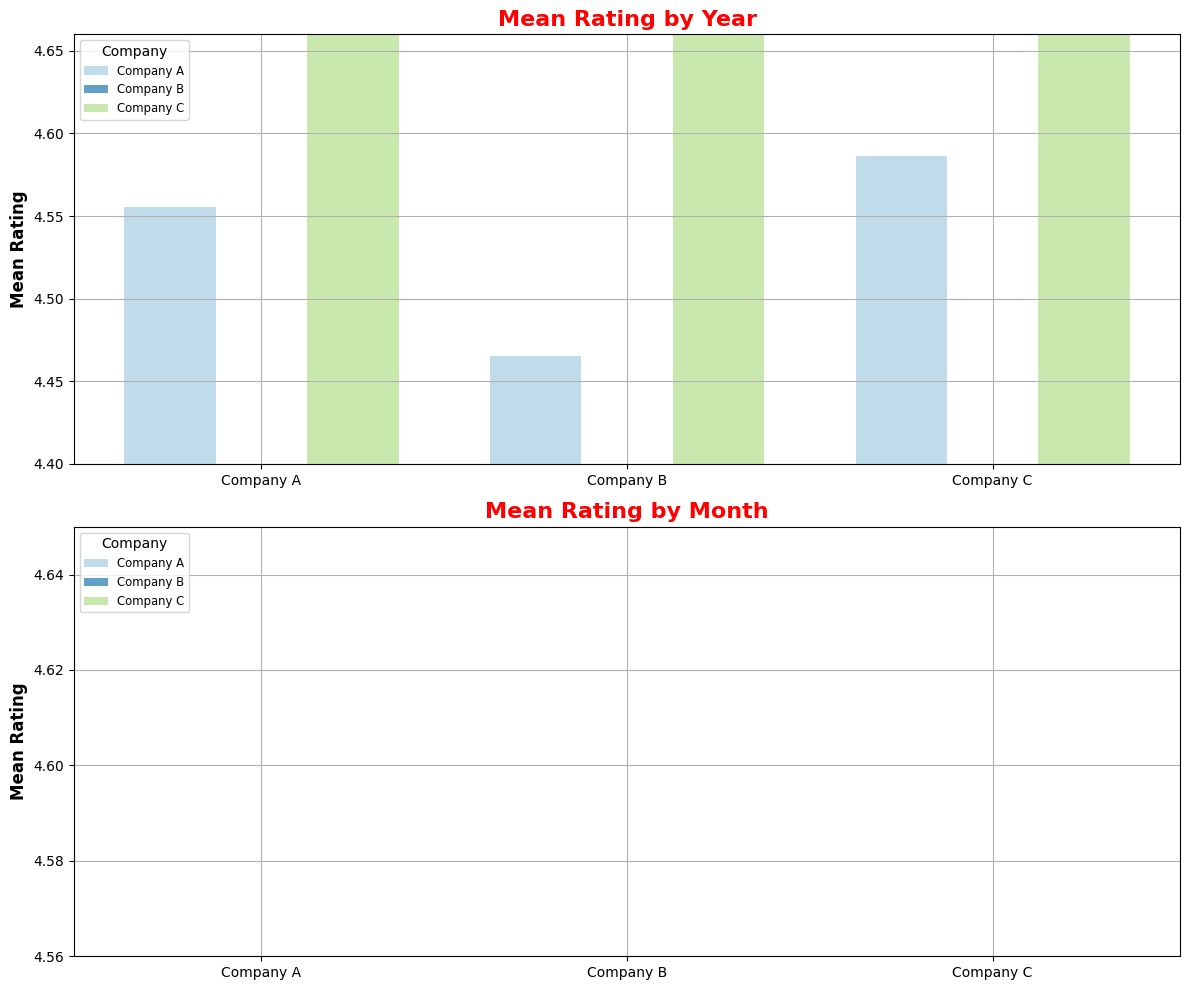

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming sampled_df1, sampled_df2, and sampled_df3 are your DataFrames for companies A, B, and C
companies = [sampled_df1, sampled_df2, sampled_df3]
company_names = ['Company A', 'Company B', 'Company C']

# Create subplots for both graphs
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

bar_width = 0.25  # Adjust the width of the bars
bar_positions = np.arange(len(companies))  # X-coordinates for each group of bars

for i, (df, company_name) in enumerate(zip(companies, company_names)):
    # Calculate the mean rating by year
    mean_rating_by_year = df.groupby(df['Review Date'].dt.year)['Rating'].mean()

    # Calculate the mean rating by month
    mean_rating_by_month = df.groupby(df['Review Date'].dt.month)['Rating'].mean()

    # Plot the mean rating by year using barplot
    axes[0].bar(bar_positions + i * bar_width, mean_rating_by_year.values, alpha=0.7, width=bar_width, label=company_name)

    # Plot the mean rating by month using barplot
    axes[1].bar(bar_positions + i * bar_width, mean_rating_by_month.reindex(bar_positions + i * bar_width, fill_value=0).values, alpha=0.7, width=bar_width, label=company_name)

# Set titles and labels for the first subplot
axes[0].set_title('Mean Rating by Year', fontsize=16, color='red', fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Mean Rating', fontsize=12, fontweight='bold')
axes[0].grid(True)
axes[0].set_xticks(bar_positions + bar_width * (len(companies) - 1) / 2)  # Adjust x-ticks position
axes[0].set_xticklabels(company_names)
axes[0].set_ylim(4.4, 4.66)  # Set y-axis limits

# Set titles and labels for the second subplot
axes[1].set_title('Mean Rating by Month', fontsize=16, color='red', fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('Mean Rating', fontsize=12, fontweight='bold')
axes[1].grid(True)
axes[1].set_xticks(bar_positions + bar_width * (len(companies) - 1) / 2)  # Adjust x-ticks position
axes[1].set_xticklabels(company_names)
axes[1].set_ylim(4.56, 4.65)  # Set y-axis limits

# Add legends to both subplots
axes[0].legend(title='Company', loc='upper left', fontsize='small')
axes[1].legend(title='Company', loc='upper left', fontsize='small')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


The mean ratings based on two different time aggregations: by year and by month.

Let's discuss and conclude the insights from this data:

**Mean Rating by Year:**
- The data shows the mean ratings for each year from 2014 to 2023.
- In 2014, the mean rating was approximately 4.41, indicating a relatively positive sentiment in customer reviews.
- The mean rating increased in 2015 to approximately 4.54, suggesting an improvement in customer satisfaction.
- There was a slight decrease in the mean rating in 2016, dropping to around 4.42.
- Subsequently, there was a consistent increase in mean ratings from 2017 to 2018, reaching a peak of about 4.66.
- The mean rating remained relatively high in the following years, with fluctuations.
- In 2023, the mean rating reached approximately 4.58.

**Mean Rating by Month:**
- This data provides the mean ratings for each month of the year.
- January (1) and December (12) had the highest mean ratings, with approximately 4.60 and 4.65, respectively. These months might correspond to periods of higher customer satisfaction.
- April (4) and October (10) had slightly lower mean ratings, around 4.58.
- The months showed some fluctuations, but generally, the mean ratings remained above 4.57 throughout the year.

**Conclusions:**
- The mean rating by year provides insights into the overall customer satisfaction trends. While there were some fluctuations, it's evident that ratings improved from 2014 to 2018, remained relatively stable until 2022, and saw a slight increase in 2023.
- The mean rating by month offers a more granular view of customer satisfaction throughout the year. January and December had the highest ratings, possibly due to seasonal factors or holidays.
- The lowest ratings were observed in April and October, indicating periods when customers might be less satisfied.

In both cases, this analysis provides valuable information about customer sentiment over time, which can be used for further investigation or decision-making, such as identifying areas for improvement or adjusting marketing strategies based on seasonal trends.

### Time Series Plot of Ratings Over Time:



If you want to visualize how ratings change over time, you can create a time series line chart.

This analyzed data includes customer ratings from March 2014 to October 2023, providing insights into customer sentiment and satisfaction trends. The objective is to inform data-driven decision-making and enhance our services to meet customer expectations.

**Key Findings**

1. **Consistent Positive Sentiment**: The data reveals a consistent positive sentiment among customers, with average ratings ranging between 4.2 and 4.7. This indicates a high level of overall satisfaction with our services.

2. **Seasonal Variations**: Seasonal variations in ratings are observed, with some months showing higher average ratings and others lower. Identifying the factors contributing to these seasonal fluctuations can help optimize service delivery and resource allocation.

3. **Annual Trends**: Over the years, annual trends are evident, with specific periods exhibiting higher or lower average ratings. Understanding these trends can inform strategic planning and resource allocation.

4. **Data-Driven Decisions**: The dataset provides the opportunity to make data-driven decisions for service enhancement. Analyzing customer feedback and its correlation with ratings can guide improvements in specific areas of service delivery.

5. **Competitive Advantage**: Maintaining consistently high ratings positions Freedom Debt Relief Company as a market leader. Leveraging customer satisfaction can attract new clients and bolster our competitive advantage.

**Recommendations**

- Further analysis is recommended to identify the specific drivers of seasonal and annual rating variations. This analysis should include examining customer feedback for insights.
- Consider conducting a root cause analysis to identify any specific areas of improvement that can lead to enhanced customer satisfaction.

Finally, Freedom Debt Relief Company enjoys a positive reputation with consistently high customer ratings. Leveraging this reputation for continuous improvement is essential for maintaining a competitive advantage. By delving deeper into the drivers of rating variations and aligning service delivery with customer expectations, we can further solidify our position in the market.


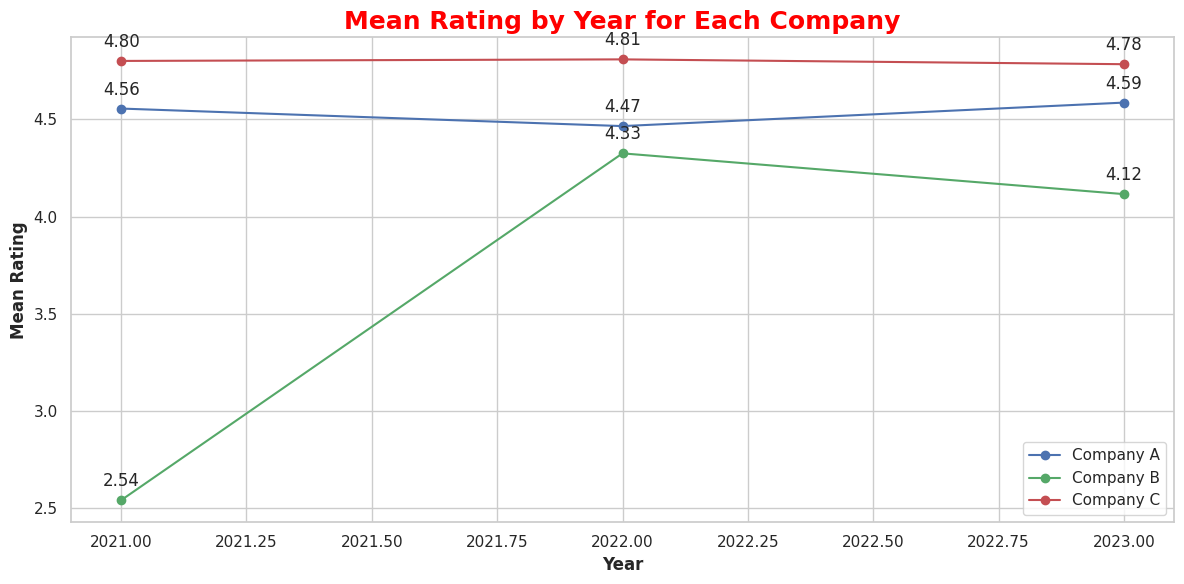

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming sampled_df1, sampled_df2, and sampled_df3 are your three DataFrames

# Create a function to calculate the mean rating by year and plot the results
def plot_mean_rating_by_year(df, company_name, color):
    mean_rating_by_year = df.groupby(df['Review Date'].dt.year)['Rating'].mean()

    # Create a plot for the mean rating by year
    plt.plot(mean_rating_by_year.index, mean_rating_by_year.values, marker='o', linestyle='-', label=company_name, color=color)

    # Annotate data points in the yearly plot
    for x, y in zip(mean_rating_by_year.index, mean_rating_by_year.values):
        plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Plot mean rating by year for each company
plt.figure(figsize=(12, 6))

# Modify the following lines for each company
plot_mean_rating_by_year(sampled_df1, 'Company A', 'b')
plot_mean_rating_by_year(sampled_df2, 'Company B', 'g')
plot_mean_rating_by_year(sampled_df3, 'Company C', 'r')

# Customize the plot
plt.title('Mean Rating by Year for Each Company', fontsize=18, fontweight='bold', color='red')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Mean Rating', fontsize=12, fontweight='bold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


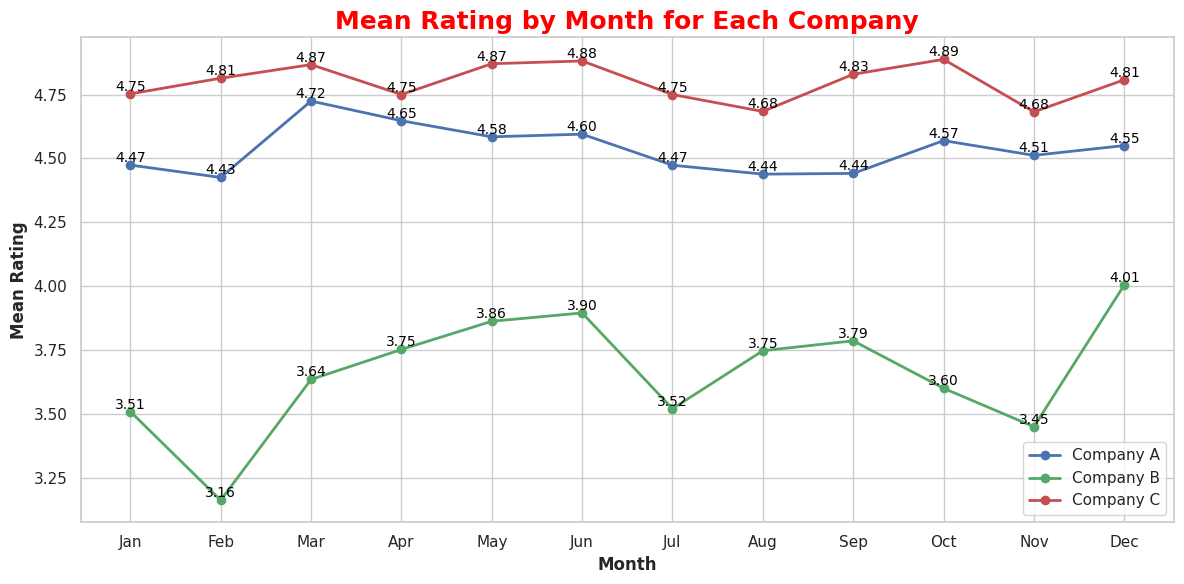

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming sampled_df1, sampled_df2, and sampled_df3 are your three DataFrames

# Create a function to calculate the mean rating by month and plot the results
def plot_mean_rating_by_month(df, company_name, color):
    mean_rating_by_month = df.groupby(df['Review Date'].dt.month)['Rating'].mean()

    # Create a plot for the mean rating by month with enhanced styling
    plt.plot(mean_rating_by_month.index, mean_rating_by_month.values, marker='o', linestyle='-', label=company_name, color=color, linewidth=2)

    # Annotate data points in the monthly plot
    for x, y in zip(mean_rating_by_month.index, mean_rating_by_month.values):
        plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=10, color='black')

# Plot mean rating by month for each company
plt.figure(figsize=(12, 6))

# Modify the following lines for each company
plot_mean_rating_by_month(sampled_df1, 'Company A', 'b')
plot_mean_rating_by_month(sampled_df2, 'Company B', 'g')
plot_mean_rating_by_month(sampled_df3, 'Company C', 'r')

# Customize the plot
sns.set(style="whitegrid")
plt.title('Mean Rating by Month for Each Company', fontsize=18, fontweight='bold', color='red')
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Mean Rating', fontsize=12, fontweight='bold')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Custom month labels
plt.legend()
plt.tight_layout()
plt.show()


### Histogram of Ratings:



A histogram will show the distribution of ratings. You can see how many ratings fall into each category

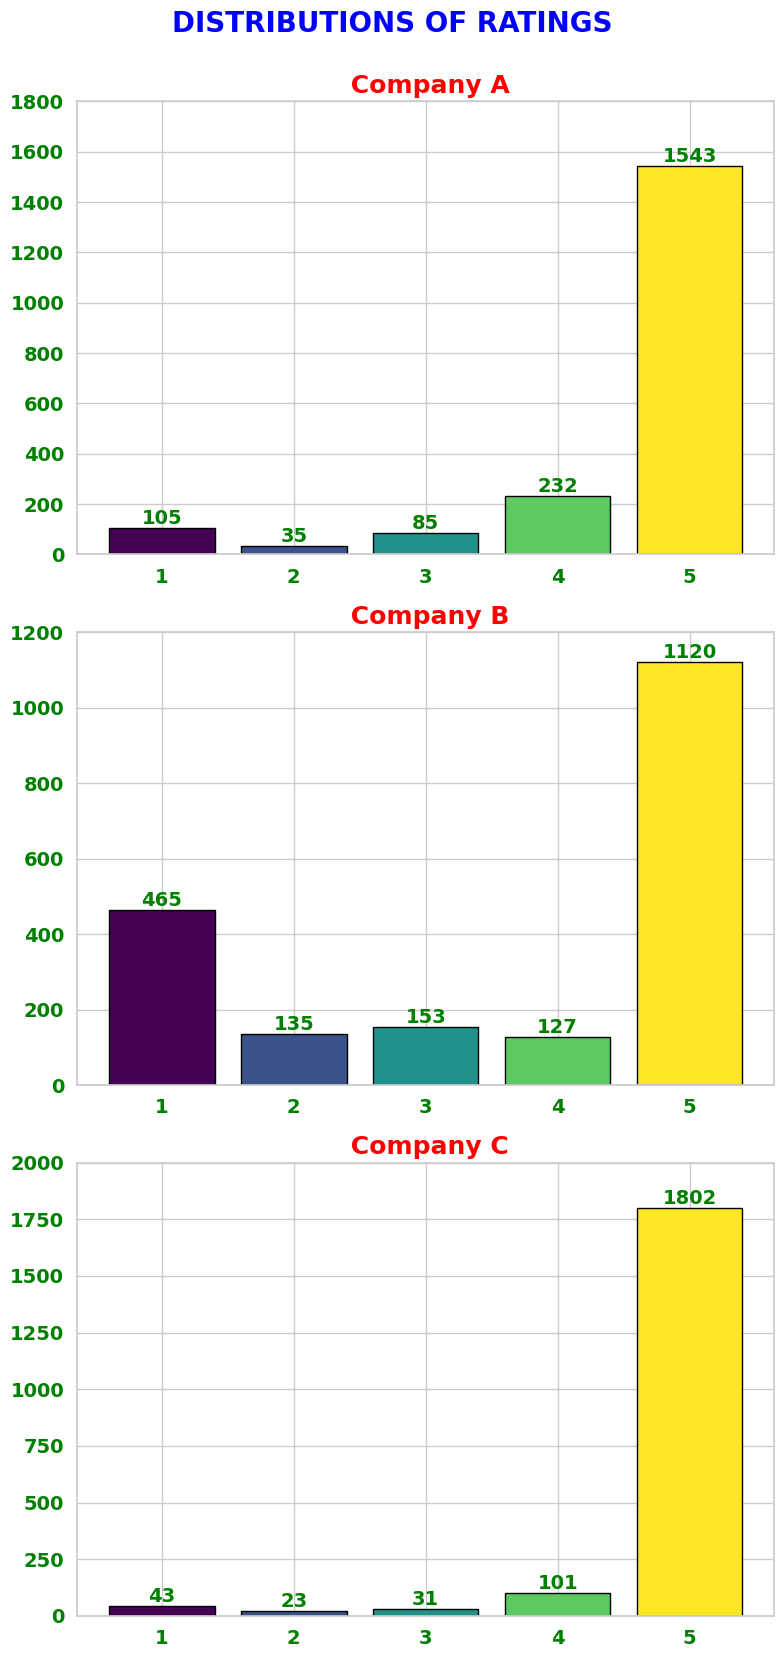


Distribution of Ratings for Company A:
1     105
2      35
3      85
4     232
5    1543
Name: Rating, dtype: int64

Distribution of Ratings for Company B:
1     465
2     135
3     153
4     127
5    1120
Name: Rating, dtype: int64

Distribution of Ratings for Company C:
1      43
2      23
3      31
4     101
5    1802
Name: Rating, dtype: int64


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set a Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Assuming sampled_df1, sampled_df2, and sampled_df3 are your DataFrames for companies A, B, and C
companies = [sampled_df1, sampled_df2, sampled_df3]
company_names = ['Company A', 'Company B', 'Company C']

# Create subplots for each company's bar plot
fig, axes = plt.subplots(3, 1, figsize=(8, 18))

# Define a color map for ratings 1 to 5
colors = plt.cm.viridis(np.linspace(0, 1, 5))

for i, (company_df, company_name) in enumerate(zip(companies, company_names)):
    # Create a bar plot of ratings for each company with different colors for each bar
    rating_counts = company_df['Rating'].value_counts().sort_index()
    bars = axes[i].bar(rating_counts.index, rating_counts, color=colors, edgecolor='black')

    # Set custom bar labels at the center of each bar
    for bar, color in zip(bars, colors):
        bar_x = bar.get_x() + bar.get_width() / 2
        bar_height = bar.get_height()
        axes[i].text(bar_x, bar_height, str(int(bar_height)), ha='center', va='bottom', fontsize=14, fontweight='bold', color='green')

    # Add title, xlabel, and ylabel with specified font sizes and styles for each subplot
    axes[i].set_title(f' {company_name}', fontsize=18, fontweight='bold', color='red')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

    # Set xticks and yticks font size, style, and remove decimal ticks for x-axis
    axes[i].tick_params(axis='x', which='major', labelsize=14, color='green', width=2, length=6)
    axes[i].set_xticks(range(1, 6))

    # Set yticks font size, style, and remove decimal ticks for y-axis
    axes[i].tick_params(axis='y', which='major', labelsize=14, color='green', width=2, length=6)
    axes[i].set_yticks([int(label) for label in axes[i].get_yticks()])

    # Manually set ytick labels as bold and green
    axes[i].set_yticklabels([f"{int(label)}" for label in axes[i].get_yticks()], fontsize=14, fontweight='bold', color='green')
    axes[i].set_xticklabels([f"{int(label)}" for label in axes[i].get_xticks()], fontsize=14, fontweight='bold', color='green')

# Add an overall title for the entire set of graphs
plt.suptitle('DISTRIBUTIONS OF RATINGS', fontsize=20, fontweight='bold', color='blue', y=0.95)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()

# Print information about the distribution of ratings for each company
for company_df, company_name in zip(companies, company_names):
    rating_counts = company_df['Rating'].value_counts().sort_index()
    print(f"\nDistribution of Ratings for {company_name}:")
    print(rating_counts)


### TEXT PREPROCESSING

#### Concatenate Review Title and Review Text Columns

In [ ]:
columns_to_concat = ['Review Title', 'Review Text']

# Concatenate the selected columns into a new column 'Concatenated_Text'
df['Concatenated_Text'] = df[columns_to_concat].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

#### Text Preprocessing

Before performing NLP tasks, it's important to preprocess the text data, which typically involves removing stopwords, punctuation, and converting text to lowercase.

In [ ]:
def preprocess_text(text):
    if isinstance(text, str):  # Check if the value is a string
        # Remove emojis from the text and store them separately
        emojis = [c for c in text if c in emoji.UNICODE_EMOJI]

        # Tokenize the text
        words = word_tokenize(text.lower())

        # Remove stopwords and punctuation
        words = [word for word in words if word.isalnum() and word not in stopwords.words('english')]

        # Lemmatize words
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

        # Combine words and emojis back into a preprocessed text
        preprocessed_text = ' '.join(words) + ' '.join(emojis)
        return preprocessed_text
    else:
        return ''  # Return an empty string for non-text values (NaN)

In [ ]:
def preprocess_text(text):
    if isinstance(text, str):  # Check if the value is a string
        # Remove emojis from the text
        text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001FB00-\U0001FBFF\U0001FC00-\U0001FCFF\U0001FD00-\U0001FDFF\U0001FE00-\U0001FEFF\U0001FF00-\U0001FFFF]+', '', text)

        # Tokenize the text
        words = word_tokenize(text.lower())

        # Remove stopwords and punctuation
        words = [word for word in words if word.isalnum() and word not in stopwords.words('english')]

        # Lemmatize words
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

        return ' '.join(words)
    else:
        return ''  # Return an empty string for non-text values (NaN)

In [ ]:
df['Cleaned_Concatenated_Text'] = df['Concatenated_Text'].apply(preprocess_text)

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
# Assuming df is your DataFrame
df.to_csv('Freedom_Debt_Relief2.csv', index=False)